# Data Exploration and Analysis of House Price Offers

# 1. Introduction

# 2. Dataset Characteristics

## 2.1. Preparing the Data

In [57]:
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.graph_objs import Scattermapbox, Layout, Figure
import plotly.express as px
from scipy.stats.mstats import mquantiles_cimj, median_cihs
from scipy.stats import bootstrap
import itertools

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [58]:
house_df = pd.read_csv('Scraped_Data/jabodetabek_house_price.csv')

## 2.2. Dataset Features

#### **Features List**

In [59]:
features = house_df.sample(1).T.rename_axis('features', axis='columns')

features

features                                                           3292
url                   https://www.rumah123.com/properti/tangerang/ho...
price_in_rp                                              980,000,000.00
title                 JUAL MURAH RUMAH 1 LANTAI DI SUVARNA SUTERA, T...
address                                               Cikupa, Tangerang
district                                                         Cikupa
city                                                          Tangerang
lat                                                               -6.22
long                                                             106.51
facilities             Lapangan Voli,  Keamanan,  Tempat Gym, Lapang...
property_type                                                     rumah
ads_id                                                      hos11294409
bedrooms                                                           2.00
bathrooms                                                          1.00
land_size_m2                                                     136.00
building_size_m2                                                  84.00
carports                                                           1.00
certificate                                  shm - sertifikat hak milik
electricity                                                    2200 mah
maid_bedrooms                                                      1.00
maid_bathrooms                                                     1.00
floors                                                             1.00
building_age                                                        NaN
year_built                                                          NaN
property_condition                                                bagus
building_orientation                                              utara
garages                                                            0.00
furnishing                                                  unfurnished

The feature names are quite understandable and the values are not ambiguous.

#### **Data types of each Features**

We will apply data types of each features accordingly as explained as below:

1. Some features that explains *number of instances* (e.g. number of `garages` provided) is best explained as an integer. For convenience, we will cast the datatypes of those features.

2. Some features fall into *categorical* datatypes (e.g. `certificate`) and some categories naturally have order (e.g. `electricity`)

In [60]:
cast_int_cols_indices = [
    (i, format) for i, format in zip(
        [11, 12, 15, 18, 19, 20, 21, 22, 25], itertools.repeat('Int64')
        )
    ]
cast_categorical_cols_indices = [
    (i, format) for i, format in zip(
        [9, 16, 17, 23, 24, 26], itertools.repeat('category')
        )
    ]
for index, format in (
        cast_int_cols_indices 
        + cast_categorical_cols_indices):
    house_df.iloc[:, index] = house_df.iloc[:, index].astype(format, errors='ignore')
    
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   url                   3553 non-null   object  
 1   price_in_rp           3553 non-null   float64 
 2   title                 3553 non-null   object  
 3   address               3553 non-null   object  
 4   district              3553 non-null   object  
 5   city                  3553 non-null   object  
 6   lat                   3553 non-null   float64 
 7   long                  3553 non-null   float64 
 8   facilities            3553 non-null   object  
 9   property_type         3552 non-null   category
 10  ads_id                3549 non-null   object  
 11  bedrooms              3519 non-null   Int64   
 12  bathrooms             3524 non-null   Int64   
 13  land_size_m2          3551 non-null   float64 
 14  building_size_m2      3551 non-null   float64 
 15  carp

Let's inspect each of the categorical column:

In [61]:
category_columns = \
    house_df.select_dtypes(include='category').columns

for column in category_columns:
    categories = list(house_df[column].dtypes.categories)
    print(column, '. Categories: ', categories, '\n')

property_type . Categories:  ['rumah'] 

certificate . Categories:  ['hgb - hak guna bangunan', 'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)', 'shm - sertifikat hak milik'] 

electricity . Categories:  ['10000 mah', '10600 mah', '11000 mah', '12700 mah', '1300 mah', '13200 mah', '13300 mah', '13900 mah', '16500 mah', '17600 mah', '2200 mah', '22000 mah', '23000 mah', '24000 mah', '3300 mah', '33000 mah', '3500 mah', '41500 mah', '4400 mah', '450 mah', '47500 mah', '53000 mah', '5500 mah', '6600 mah', '7600 mah', '7700 mah', '8000 mah', '900 mah', '9500 mah', 'lainnya mah'] 

property_condition . Categories:  ['bagus', 'bagus sekali', 'baru', 'butuh renovasi', 'semi furnished', 'sudah renovasi', 'unfurnished'] 

building_orientation . Categories:  ['barat', 'barat daya', 'barat laut', 'selatan', 'tenggara', 'timur', 'timur laut', 'utara'] 

furnishing . Categories:  ['baru', 'furnished', 'semi furnished', 'unfurnished'] 



Several features have mixed record of categories (for example, `property_condition` has furnishing records, so has `furnishing`) and deemed inconsistent for ordering this categories. Nevertheless, we will order as possible.

For non-ambiguous categories: `certificate` and `electricity`, will be ordered as follows:

1. Certificate categories order shall be: `1) SHM; 2) HGB; 3) HP; 4) lainnya`.
2. Electricity order shall be based on its energy charge

In [62]:
def sort_elect(string_value):
    num_value = re.findall(r'\d+', string_value)
    if len(num_value) == 0:
        return 0
    else:
        return int(num_value[0])

certificate_order = [
    'shm - sertifikat hak milik', 'hgb - hak guna bangunan', 
    'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)'
    ]
electricity_order = sorted(
    list(house_df['electricity'].dtypes.categories),
    key=sort_elect
    )
property_condition_order = [
     'baru', 'bagus sekali', 'bagus', 'sudah renovasi',
     'butuh renovasi', 'semi furnished', 'unfurnished'
    ]
furnishing_order = [
    'furnished', 'semi furnished', 'unfurnished', 'baru'
    ]
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df[column] = \
        pd.Categorical(
            values=house_df[column],
            categories=order,
            ordered=True
            )

#### **'Facilities' Features**

In [63]:
house_df = house_df.assign(
    facilities = house_df.facilities.str.split(', ')
)
for index, facilities in enumerate(house_df.facilities.values):
    for facility in facilities:
        facility_formatted = facility.lower().strip().replace(' ', '_')
        if facility_formatted:
            house_df.loc[house_df.index == index, f'fac_{facility_formatted}'] = 1  

In [64]:
# (delete, preserve)
col_pair_duplicated = [
    ('fac_keamanan_24_jam', 'fac_keamanan'),
    ('fac_track_lari', 'fac_jogging_track'),
    ('fac_tempat_laundry', 'fac_tempat_jemuran'),
    ('fac_taman', 'fac_garden'),
    ('fac_carport', 'fac_akses_parkir'),
    ('fac_pemanas_air', 'fac_water_heater'),
    ('fac_kompor', 'fac_kitchen_set'),
    ('fac_2_unit_ac', 'fac_ac'),
    ('fac_carport_1_mobil', 'fac_akses_parkir'),
    ('fac_security_24_jam', 'fac_keamanan'),
    ('fac_pool', 'fac_kolam_renang'),
    ('fac_private_pool', 'fac_kolam_renang'),
    ('fac_kolam_renang_anak', 'fac_kolam_renang'),
    ('fac_kitchen_set_(opsional)', 'fac_kitchen_set'),
    ('fac_security24_jam', 'fac_keamanan'),
    ('fac_taman_luas', 'fac_garden'),
    ('fac_musholla_exclusive', 'fac_masjid'),
    ('fac_toren_500_liter', 'fac_plumbing_system'),
    ('fac_torn_650ltr', 'fac_plumbing_system'),
    ('fac_one_gate_sistem', 'fac_one_gate_system'),
    ('fac_torn_air', 'fac_plumbing_system'),
    ('fac_jetpump', 'fac_plumbing_system'),
    ('fac_cctv_area', 'fac_cctv'),
    ('fac_mushola', 'fac_masjid'),
    ('fac_security_24h', 'fac_keamanan'),
    ('fac_taman_minimalis', 'fac_garden'),
    ('fac_swimming_pool', 'fac_kolam_renang'),
    ('fac_full_kitchen_set', 'fac_kitchen_set'),
    ('fac_ac_2_unit', 'fac_ac'),
    ('fac_ac_3_unit', 'fac_ac'),
    ('fac_free_kitchen_set', 'fac_kitchen_set'),
    ('fac_onegate', 'fac_one_gate_system'),
    ('fac_security_24jam', 'fac_keamanan'),
    ('fac_1_unit_ac', 'fac_ac'),
    ('fac_securty_24_jam', 'fac_keamanan'),
    ('fac_carport_2_mobil', 'fac_akses_parkir'),
    ('fac_smart_lock_door', 'fac_smart_home'),
    ('fac_torrent', 'fac_plumbing_system'),
    ('fac_servis_area', 'fac_service_area'),
    ('fac_smarthome', 'fac_smart_home', ),
    ('fac_dapur_bersih_dan_kotor', 'fac_wastafel')
    ]
fac_to_drop = [
    'fac_posisi_hoek', 'fac_void', 'fac_living_room',
    'fac_lemari_kayu', 'fac_pagar'
    ]
for delete, preserve in col_pair_duplicated:
    try:
        house_df.loc[house_df[delete] == 1, preserve] == 1
    except KeyError:
        house_df[preserve] = 0
        house_df.loc[house_df[delete] == 1, preserve] == 1
    house_df.drop(
     delete, axis=1, inplace=True   
    )
house_df.drop(
    fac_to_drop, axis=1, inplace=True
)

In [65]:
fac_columns = house_df.columns[pd.Series(house_df.columns).str.contains('fac_.*', regex=True)]
n_ = len(fac_columns)
fillna_fac = dict([(i) for i in zip(
    fac_columns, 
    list(itertools.repeat(0, n_)))
    ])
house_df.fillna(fillna_fac, inplace=True)
house_df.loc[:, list(fac_columns)] = house_df.loc[:, list(fac_columns)].astype('Int64', errors='ignore')

house_df.sample(3).T

2686  \
url                               https://www.rumah123.com/properti/jakarta-pusa...   
price_in_rp                                                        5,800,000,000.00   
title                             Rumah bagus kost mewah dekat gedung kuningan j...   
address                                                 Menteng Atas, Jakarta Pusat   
district                                                               Menteng Atas   
city                                                                  Jakarta Pusat   
lat                                                                           -6.20   
long                                                                         106.84   
facilities                                                   [Taman, Keamanan,  Ac]   
property_type                                                                 rumah   
ads_id                                                                  hos10929593   
bedrooms                                                                          8   
bathrooms                                                                         7   
land_size_m2                                                                 215.00   
building_size_m2                                                             400.00   
carports                                                                          1   
certificate                                              shm - sertifikat hak milik   
electricity                                                                3500 mah   
maid_bedrooms                                                                     1   
maid_bathrooms                                                                    1   
floors                                                                            2   
building_age                                                                     12   
year_built                                                                     2010   
property_condition                                                            bagus   
building_orientation                                                     barat daya   
garages                                                                           1   
furnishing                                                              unfurnished   
fac_tempat_jemuran                                                                0   
fac_jalur_telepon                                                                 0   
fac_jogging_track                                                                 0   
fac_kolam_renang                                                                  0   
fac_masjid                                                                        0   
fac_keamanan                                                                      1   
fac_cctv                                                                          0   
fac_kitchen_set                                                                   0   
fac_one_gate_system                                                               0   
fac_akses_parkir                                                                  0   
fac_playground                                                                    0   
fac_wastafel                                                                      0   
fac_ac                                                                            1   
fac_lapangan_basket                                                               0   
fac_tempat_gym                                                                    0   
fac_kolam_ikan                                                                    0   
fac_lapangan_voli                                                                 0   
fac_lapangan_tenis                                                                0   
fac_lapangan_bola                                                            

## 2.3. Features with Suspicious Records

The most simple way to detect anomaly in the records is by taking a quick glance in the dataset summary:

In [66]:
house_df.describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean               std  \
price_in_rp                      3,553.00 4,191,684,773.43 13,750,673,820.54   
lat                              3,553.00            -6.32              0.13   
long                             3,553.00           106.79              0.17   
bedrooms                         3,519.00             3.33              2.67   
bathrooms                        3,524.00             2.62              2.70   
land_size_m2                     3,551.00           204.81            402.13   
building_size_m2                 3,551.00           186.59            248.44   
carports                         3,553.00             1.20              1.11   
maid_bedrooms                    3,553.00             0.50              0.69   
maid_bathrooms                   3,553.00             0.37              0.54   
floors                           3,547.00             1.76              0.64   
building_age                     2,108.00             3.88              7.60   
year_built                       2,108.00         2,018.14              7.64   
garages                          3,553.00             0.71              1.31   
fac_tempat_jemuran               3,553.00             0.28              0.45   
fac_jalur_telepon                3,553.00             0.36              0.48   
fac_jogging_track                3,553.00             0.31              0.46   
fac_kolam_renang                 3,553.00             0.26              0.44   
fac_masjid                       3,553.00             0.29              0.45   
fac_keamanan                     3,553.00             0.66              0.47   
fac_cctv                         3,553.00             0.29              0.45   
fac_kitchen_set                  3,553.00             0.13              0.34   
fac_one_gate_system              3,553.00             0.21              0.41   
fac_akses_parkir                 3,553.00             0.13              0.33   
fac_playground                   3,553.00             0.13              0.34   
fac_wastafel                     3,553.00             0.21              0.41   
fac_ac                           3,553.00             0.38              0.49   
fac_lapangan_basket              3,553.00             0.06              0.24   
fac_tempat_gym                   3,553.00             0.05              0.22   
fac_kolam_ikan                   3,553.00             0.02              0.13   
fac_lapangan_voli                3,553.00             0.04              0.19   
fac_lapangan_tenis               3,553.00             0.05              0.21   
fac_lapangan_bola                3,553.00             0.04              0.20   
fac_mesin_cuci                   3,553.00             0.02              0.15   
fac_lapangan_bulu_tangkis        3,553.00             0.05              0.22   
fac_kulkas                       3,553.00             0.03              0.17   
fac_garden                       3,553.00             0.00              0.03   
fac_water_heater                 3,553.00             0.00              0.03   
fac_canopy                       3,553.00             0.00              0.03   
fac_smart_home                   3,553.00             0.00              0.02   
fac_backyard_luas                3,553.00             0.00              0.02   
fac_garasi                       3,553.00             0.00              0.02   
fac_balkon                       3,553.00             0.00              0.02   
fac_pompa_air_wasser_dan_booster 3,553.00             0.00              0.02   
fac_kompor_exhaust               3,553.00             0.00              0.02   
fac_basement                     3,553.00             0.00              0.02   
fac_gudang                       3,553.00             0.00              0.02   
fac_clubhouse                    3,553.00             0.00              0.02   
fac_service_area                 3,553.00             0.00              0.02   
fac_plumbing_system              3,5

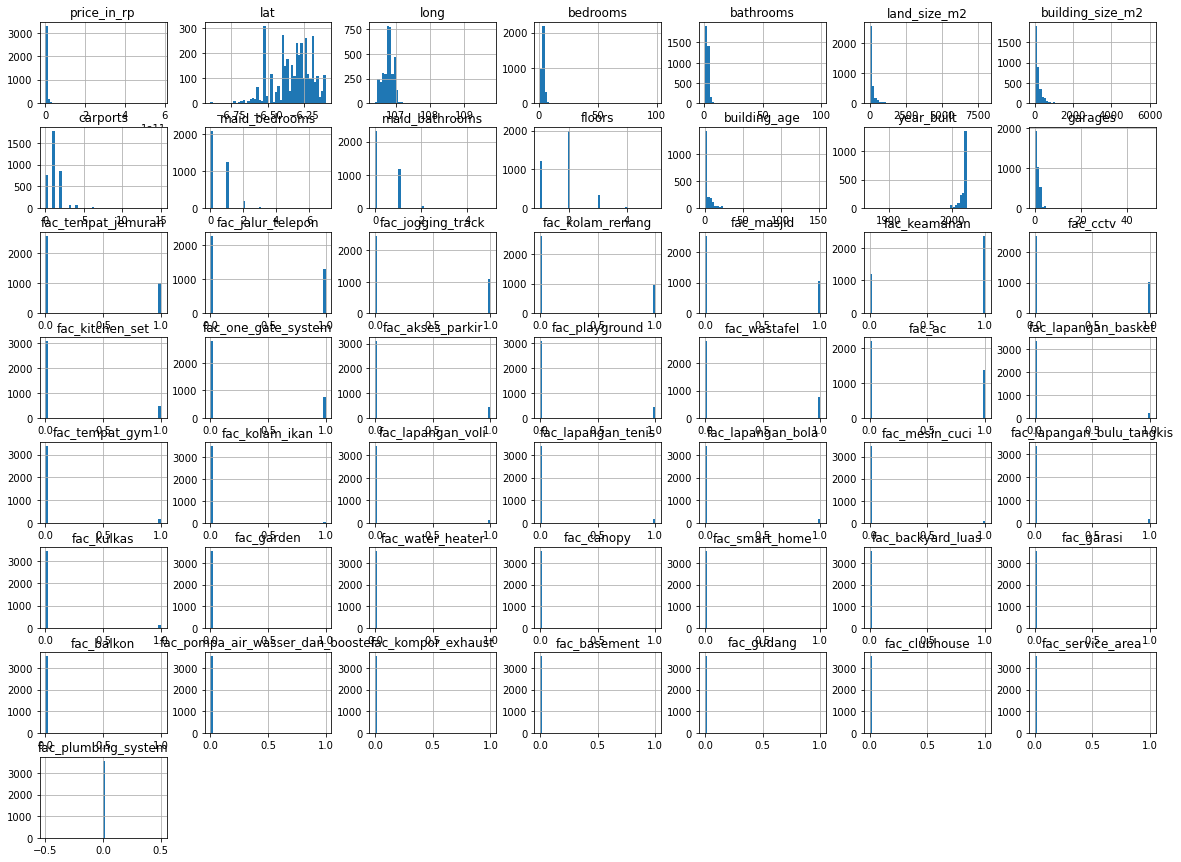

In [67]:
house_df.hist(bins=50, figsize=(20,15), )
plt.show()

#### **Price Records**

In [68]:
{"tags": ["hide-input"]}

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean               std           min  \
price_in_rp 3,553.00 4,191,684,773.43 13,750,673,820.54 42,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 580,000,000,000.00

Surely, standard deviation of `price_in_rp` is inflated by a nonproportionally large maximum price records. Currently largest value is Rp. 580 Billion. After inspecting, turns out that in the description, it explains that the price should be Rp. 5.8 Billion.

In [69]:
house_df.loc[house_df.price_in_rp == 580000000000, 'price_in_rp'] = 5800000000

The minimum price is also suspicious for typical house price in Jabodetabek (only Rp. 42 million). 

In [70]:
minimum_price = house_df.loc[
        house_df.price_in_rp == 42000000, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ]
minimum_price

url   price_in_rp  \
159  https://www.rumah123.com/properti/bekasi/hos11... 42,000,000.00   
340  https://www.rumah123.com/properti/bekasi/hos11... 42,000,000.00   

     bedrooms  land_size_m2  building_size_m2  floors  
159         2         60.00             40.00       1  
340         2         60.00             40.00       1

After further inspection, turns out those records are house listing offer for *Credit Transfer*, and the price records are the *Credit Transfer Fee*. We should remove those records and other *Credit Transfer* offers since those sample may disturb our price distribution and irrelevant for our subject of analysis.

In [71]:
house_df[house_df.title.str.contains(f'^oper kredit\s')]

Empty DataFrame
Columns: [url, price_in_rp, title, address, district, city, lat, long, facilities, property_type, ads_id, bedrooms, bathrooms, land_size_m2, building_size_m2, carports, certificate, electricity, maid_bedrooms, maid_bathrooms, floors, building_age, year_built, property_condition, building_orientation, garages, furnishing, fac_tempat_jemuran, fac_jalur_telepon, fac_jogging_track, fac_kolam_renang, fac_masjid, fac_keamanan, fac_cctv, fac_kitchen_set, fac_one_gate_system, fac_akses_parkir, fac_playground, fac_wastafel, fac_ac, fac_lapangan_basket, fac_tempat_gym, fac_kolam_ikan, fac_lapangan_voli, fac_lapangan_tenis, fac_lapangan_bola, fac_mesin_cuci, fac_lapangan_bulu_tangkis, fac_kulkas, fac_garden, fac_water_heater, fac_canopy, fac_smart_home, fac_backyard_luas, fac_garasi, fac_balkon, fac_pompa_air_wasser_dan_booster, fac_kompor_exhaust, fac_basement, fac_gudang, fac_clubhouse, fac_service_area, fac_plumbing_system]
Index: []

In [72]:
house_df = house_df.assign(
    title=house_df.title.str.lower().replace(r'\n', ' ', regex=True).replace('*', '')
    )
title_tag_to_drop = [
    'overkredit', 'over kredit', 'oper kredit', 'operkredit', 
    'takeover', 'take over', 'take oper','oper', 'dioper', 'diover']
price_records_to_drop = [
    42000000, 70000000, 75000000, 85000000, 100000000, 130000000,
    135000000
    ]
url_to_drop = [
    'https://www.rumah123.com/properti/bogor/hos11086291/#qid~a3b85dc6-9dd7-4fa9-9eac-113f4eba7868',
    'https://www.rumah123.com/properti/tangerang/hos11359461/#qid~0d9492e8-7326-465d-85ee-e54559fedc26',
    'https://www.rumah123.com/properti/bogor/hos11351345/#qid~9ab0b10c-8ceb-4c9a-9e7a-479f91a141d1'
    ]
for tag in title_tag_to_drop:
    house_df.drop(
        house_df[house_df.title.str.contains(f'^{tag}\s')].index,
        inplace=True
    )
    house_df.drop(
        house_df[house_df.title.str.contains(f'\s{tag}\s')].index,
        inplace=True
    )
    house_df.drop(
        house_df[house_df.title.str.contains(f'\s{tag}$')].index,
        inplace=True
    )
for price in price_records_to_drop:
    house_df.drop(
        house_df[house_df.price_in_rp == price].index,
        inplace=True)
for url in url_to_drop:
    house_df.drop(
        house_df[house_df.url == url].index,
        inplace=True)
house_df[house_df.url == 'https://www.rumah123.com/properti/bekasi/hos11222131/#qid~aeb345f5-d0dd-46bf-8173-9872e4274ee2']\
    .price_in_rp == 1250000000

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean              std            min  \
price_in_rp 3,534.00 4,050,961,516.69 9,805,378,523.95 125,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 250,000,000,000.00

Above codes is our best approach to fix some minimum values.

In later chapter, we will analyze the effect of the suspicious prices using the more proven statistical approaches such as `outliers detection`, `high leverage observation`, and `cook distance`.

#### **Bedrooms & Bathrooms Records**

In [73]:
{"tags": ["hide-input"]}

house_df[['bedrooms', 'bathrooms']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count  mean  std  min  median   max
bedrooms  3,501.00  3.33 2.68 1.00    3.00 99.00
bathrooms 3,505.00  2.63 2.70 1.00    2.00 99.00

In [74]:
pd.DataFrame({
    'count':house_df[['bedrooms']].value_counts().sort_index()
}).T

bedrooms   1    2     3    4    5   6   7   8  9 10 11 12 13 16 20 21 36 37  \
count     19  940  1378  802  218  93  14  10  2  5  2  5  2  2  2  1  1  1   

bedrooms 50 54 57 99  
count     1  1  1  1

In [75]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['bathrooms']].value_counts().sort_index()
}).T

bathrooms    1     2    3    4    5   6   7   8  9 10 11 12 13 15 16 20 21 36  \
count      764  1120  978  446  111  33  20  10  3  3  2  3  1  2  1  2  1  1   

bathrooms 50 54 57 99  
count      1  1  1  1

Simple logic, house with a large amount of bedrooms/bathrooms tends to associated with large building size. House with >= 20 bedrooms may raise suspicion (especially 99!).

In [76]:
large_bedrooms_inst = house_df.loc[
        house_df.bedrooms >= 20, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ].sort_values('bedrooms')

large_bedrooms_inst

url       price_in_rp  \
2283  https://www.rumah123.com/properti/jakarta-sela... 26,000,000,000.00   
2545  https://www.rumah123.com/properti/jakarta-sela... 27,000,000,000.00   
2282  https://www.rumah123.com/properti/jakarta-sela... 26,000,000,000.00   
346   https://www.rumah123.com/properti/bekasi/hos11...  9,000,000,000.00   
1333  https://www.rumah123.com/properti/bogor/hos109...  2,700,000,000.00   
2483  https://www.rumah123.com/properti/jakarta-sela... 30,000,000,000.00   
2687  https://www.rumah123.com/properti/jakarta-sela... 28,000,000,000.00   
2634  https://www.rumah123.com/properti/jakarta-sela... 11,800,000,000.00   
2888  https://www.rumah123.com/properti/tangerang/ho... 55,000,000,000.00   

      bedrooms  land_size_m2  building_size_m2  floors  
2283        20        915.00            600.00       2  
2545        20      1,195.00            950.00       2  
2282        21        900.00            700.00       2  
346         36        939.00            500.00       1  
1333        37        500.00            350.00       1  
2483        50        517.00          2,417.00       5  
2687        54        890.00          1,800.00       5  
2634        57        491.00          1,500.00       4  
2888        99      1,150.00          6,000.00       4

Turns out that houses with large number of bedrooms is either `boarding house `(*kost*) or `guest house`.

#### **Garages**

In [77]:
{"tags": ["hide-input"]}

house_df[['garages']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count  mean  std  min  median   max
garages 3,534.00  0.71 1.31 0.00    0.00 50.00

In [78]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['garages']].value_counts().sort_index()
}).T

garages     0     1    2   3   4  5   6 10 12 20 50
count    1912  1009  518  31  42  6  10  3  1  1  1

Let's inspect house with 50 garages:

In [79]:
large_garages_inst = house_df.loc[
        house_df.garages >= 50, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors', 'garages']
    ]

large_garages_inst

url       price_in_rp  \
2888  https://www.rumah123.com/properti/tangerang/ho... 55,000,000,000.00   

      bedrooms  land_size_m2  building_size_m2  floors  garages  
2888        99      1,150.00          6,000.00       4       50

Turns out that houses with large number of garages is the house with 50 bedrooms i.e. the `boarding house `(*kost*), which explains the provided capacities for vehicle.

## 2.4. Zeroes and Missing Records

#### **Zeroes Records**

Records containing zero values are rather not ambiguous. For example, if `maid_bedrooms = 0`, it explains that this house doesn't provide bedroom for maid. Similar reasoning can safely be applied for other features, except for: `price in rp`, `lat`, `long`, `bedrooms`, `bathrooms`, `lands & building size`, and `floors`.

Let's explore proportion of zeroes records for each feature contains numerical data:

In [80]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
total_records = house_df.shape[0]
zeroes = (house_df[numerical_features] == 0).sum()
zeroes_percent = zeroes / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'Zeroes Count': zeroes, 
    'Zeroes Percentage (%)': zeroes_percent,
    'Data Types': data_types
})

Zeroes Count  Zeroes Percentage (%)  \
price_in_rp                                  0                   0.00   
lat                                          0                   0.00   
long                                         0                   0.00   
bedrooms                                     0                   0.00   
bathrooms                                    0                   0.00   
land_size_m2                                 0                   0.00   
building_size_m2                             0                   0.00   
carports                                   752                  21.28   
maid_bedrooms                             2060                  58.29   
maid_bathrooms                            2294                  64.91   
floors                                       0                   0.00   
building_age                              1044                  29.54   
year_built                                   0                   0.00   
garages                                   1912                  54.10   
fac_tempat_jemuran                        2547                  72.07   
fac_jalur_telepon                         2252                  63.72   
fac_jogging_track                         2446                  69.21   
fac_kolam_renang                          2599                  73.54   
fac_masjid                                2517                  71.22   
fac_keamanan                              1190                  33.67   
fac_cctv                                  2512                  71.08   
fac_kitchen_set                           3056                  86.47   
fac_one_gate_system                       2780                  78.66   
fac_akses_parkir                          3085                  87.29   
fac_playground                            3074                  86.98   
fac_wastafel                              2787                  78.86   
fac_ac                                    2179                  61.66   
fac_lapangan_basket                       3314                  93.77   
fac_tempat_gym                            3353                  94.88   
fac_kolam_ikan                            3473                  98.27   
fac_lapangan_voli                         3399                  96.18   
fac_lapangan_tenis                        3374                  95.47   
fac_lapangan_bola                         3380                  95.64   
fac_mesin_cuci                            3456                  97.79   
fac_lapangan_bulu_tangkis                 3351                  94.82   
fac_kulkas                                3422                  96.83   
fac_garden                                3531                  99.92   
fac_water_heater                          3530                  99.89   
fac_canopy                                3530                  99.89   
fac_smart_home                            3533                  99.97   
fac_backyard_luas                         3533                  99.97   
fac_garasi                                3532                  99.94   
fac_balkon                                3533                  99.97   
fac_pompa_air_wasser_dan_booster          3533                  99.97   
fac_kompor_exhaust                        3533                  99.97   
fac_basement                              3533                  99.97   
fac_gudang                                3533                  99.97   
fac_clubhouse                             3533                  99.97   
fac_service_area                          3533                  99.97   
fac_plumbing_system                       3534                 100.00   

                                 Data Types  
price_in_rp                         float64  
lat                                 float64  
long                                float64  
bedrooms                              Int64  
bathrooms                             Int64  
land_size_m2                      

Fortunately, primary characteristics of the house doesn't contains zeroes. 

#### **Missing Records**

Let's fist explore missing records for numerical features.

In [81]:
nans = (house_df[numerical_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

NaN Count  NaN Percentage (%) Data Types
price_in_rp                               0                0.00    float64
lat                                       0                0.00    float64
long                                      0                0.00    float64
bedrooms                                 33                0.93      Int64
bathrooms                                29                0.82      Int64
land_size_m2                              2                0.06    float64
building_size_m2                          2                0.06    float64
carports                                  0                0.00      Int64
maid_bedrooms                             0                0.00      Int64
maid_bathrooms                            0                0.00      Int64
floors                                    6                0.17      Int64
building_age                           1443               40.83      Int64
year_built                             1443               40.83      Int64
garages                                   0                0.00      Int64
fac_tempat_jemuran                        0                0.00      Int64
fac_jalur_telepon                         0                0.00      Int64
fac_jogging_track                         0                0.00      Int64
fac_kolam_renang                          0                0.00      Int64
fac_masjid                                0                0.00      Int64
fac_keamanan                              0                0.00      Int64
fac_cctv                                  0                0.00      Int64
fac_kitchen_set                           0                0.00      Int64
fac_one_gate_system                       0                0.00      Int64
fac_akses_parkir                          0                0.00      Int64
fac_playground                            0                0.00      Int64
fac_wastafel                              0                0.00      Int64
fac_ac                                    0                0.00      Int64
fac_lapangan_basket                       0                0.00      Int64
fac_tempat_gym                            0                0.00      Int64
fac_kolam_ikan                            0                0.00      Int64
fac_lapangan_voli                         0                0.00      Int64
fac_lapangan_tenis                        0                0.00      Int64
fac_lapangan_bola                         0                0.00      Int64
fac_mesin_cuci                            0                0.00      Int64
fac_lapangan_bulu_tangkis                 0                0.00      Int64
fac_kulkas                                0                0.00      Int64
fac_garden                                0                0.00      Int64
fac_water_heater                          0                0.00      Int64
fac_canopy                                0                0.00      Int64
fac_smart_home                            0                0.00      Int64
fac_backyard_luas                         0                0.00      Int64
fac_garasi                                0                0.00      Int64
fac_balkon                                0                0.00      Int64
fac_pompa_air_wasser_dan_booster          0                0.00      Int64
fac_kompor_exhaust                        0                0.00      Int64
fac_basement                              0                0.00      Int64
fac_gudang                                0                0.00      Int64
fac_clubhouse                             0                0.00      Int64
fac_service_area                          0                0.00      Int64
fac_plumbing_system                       0                0.00      Int64

Almost half of the dataset contains observations with missing `building_age`, so deducting analysis from this features is not appropriate.

For other features with missing records, it is safe to ignore those observations since they only cover less than 1% of total rows in the dataset.

For categorical and string features:

In [82]:
non_numeric_features = house_df.select_dtypes(include=['object', 'category']).columns
nans = (house_df[non_numeric_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[non_numeric_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

NaN Count  NaN Percentage (%) Data Types
url                           0                0.00     object
title                         0                0.00     object
address                       0                0.00     object
district                      0                0.00     object
city                          0                0.00     object
facilities                    0                0.00     object
property_type                 1                0.03   category
ads_id                        4                0.11     object
certificate                 141                3.99   category
electricity                   0                0.00   category
property_condition          245                6.93   category
building_orientation       1640               46.41   category
furnishing                  385               10.89   category

Other than `building_orientation`, those features suffers from zero to slightly missing records.

# 3. Data Exploration

## 3.1. Median Statistics of House Price

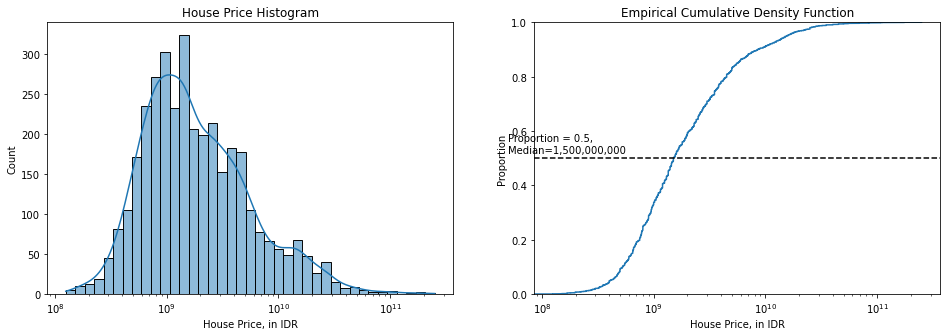

In [83]:
median = house_df['price_in_rp'].median()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=house_df, x='price_in_rp', kde=True, 
    log_scale=True, ax=ax[0]
    )
sns.ecdfplot(
    data=house_df, x='price_in_rp', log_scale=True, ax=ax[1]
)
ax[0].set_title('House Price Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

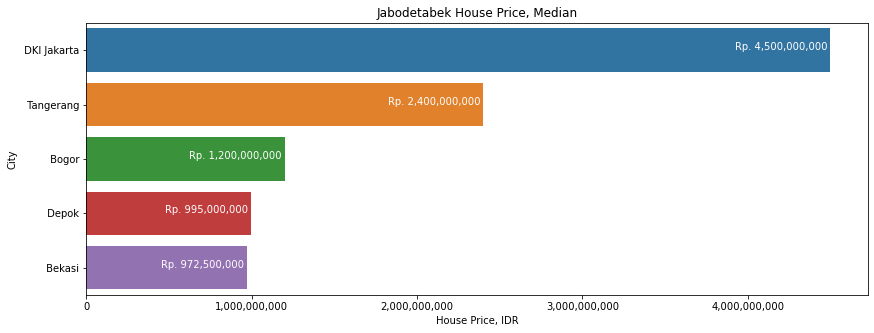

In [84]:
{"tags": ["hide-input"]}

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
median = house_df_simple[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
# plot_order = list(median.sort_values('price_in_rp', ascending=False).city)
plt.figure(figsize=(14, 5))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('Jabodetabek House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()


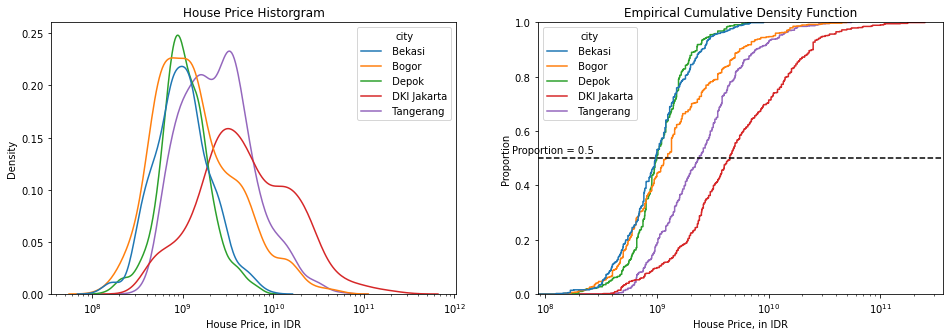

In [85]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_simple, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_simple, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

In [86]:
median_df = \
    house_df\
        .groupby('district')\
        .agg(median_price=('price_in_rp', np.median), unit_count=('price_in_rp', np.count_nonzero))\
        .reset_index()\
        .merge(house_df[['district','city', 'lat', 'long']].drop_duplicates(subset=['district']), on='district')\
        .sort_values('city')
hover_data = {
    'district': True,
    'city': True,
    'lat': False,
    'long': False,
    'median_price': ':,.0f',
    'unit_count': True
}    
fig = px.scatter_mapbox(
    median_df, lat='lat', lon='long', 
    color='city', size=(median_df.median_price / 10e3),
    hover_data=hover_data, hover_name='district'
)
fig.update_layout(
            title='Jabodetabek House Price Map',
            mapbox_style="carto-darkmatter",            
            autosize=True,
            hovermode='closest',
            )
fig.show(renderer='notebook')


#### **DKI Jakarta House Price**

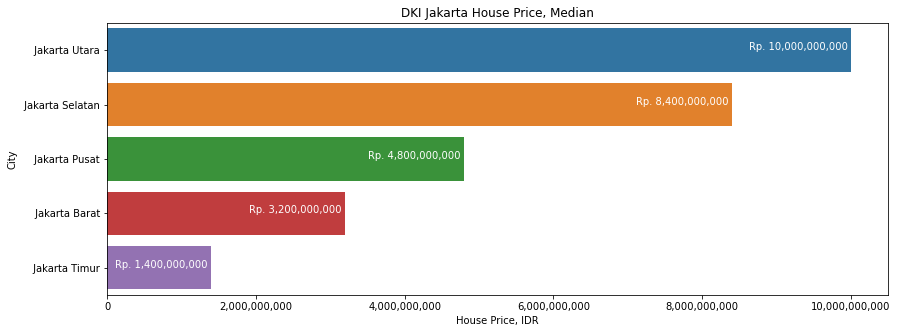

In [87]:
%matplotlib inline
house_df_jakarta = house_df[house_df.city.str.contains('Jakarta')]
median = house_df_jakarta[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
plt.figure(figsize=(14, 5))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('DKI Jakarta House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()

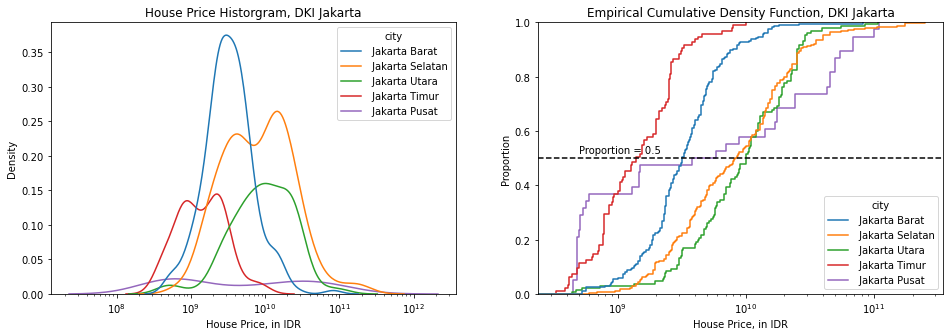

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_jakarta, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_jakarta, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram, DKI Jakarta')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e7, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function, DKI Jakarta')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

#### **Inferences about Median House Price**

In [89]:
house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean              std            min  \
price_in_rp 3,534.00 4,050,961,516.69 9,805,378,523.95 125,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 250,000,000,000.00

In [90]:
median = np.median(house_df.price_in_rp)
price_data = house_df.price_in_rp.values
median_ci_mj = [
    float(ci) for ci in mquantiles_cimj(
        data=price_data,
        prob=[0.5],
        alpha=0.05)
    ]
median_ci_hs = median_cihs(
        data=price_data,
        alpha=0.05
        )
median_ci_bootstrap = [
    float(ci) for ci in bootstrap(
        data=(price_data, ), method='percentile',
        statistic=np.median, random_state=99).confidence_interval
    ]
median_ci = [
    {'method': method, 'median':median, 'ci_lower': ci[0], 'ci_upper': ci[1]}\
        for method, median, ci in zip(
            ['Maritz-Jarrett', 'Hetmasperger-Sheather', 'Bootstrap CI'],
            [i for i in itertools.repeat(median, 3)],
            [median_ci_mj, median_ci_hs, median_ci_bootstrap]
            )
]

pd.DataFrame(median_ci)


method           median         ci_lower         ci_upper
0         Maritz-Jarrett 1,500,000,000.00 1,434,587,890.25 1,565,412,109.75
1  Hetmasperger-Sheather 1,500,000,000.00 1,450,000,000.00 1,590,000,000.00
2           Bootstrap CI 1,500,000,000.00 1,450,000,000.00 1,590,000,000.00

In [91]:
from scipy.stats import gaussian_kde

density = gaussian_kde(price_data)

In [92]:
from scipy.optimize import root_scalar

def get_cdf(upper_bound):
    density = gaussian_kde(price_data)
    return (density.integrate_box(-np.inf, upper_bound) - 0.5)

solver = root_scalar(get_cdf, method='secant',  xtol=10e-5, x0=1500000000, x1=1600000000)
print('Median: Rp. {:,.2f}'.format(solver.root))

Median: Rp. 2,147,134,676.63


In [93]:
class CoverageProba():
    def __init__(self, dataset, alpha, n_sample):
        self._dataset = dataset
        self._alpha = alpha
        self._n_sample = n_sample.copy()
        self._density = gaussian_kde(self._dataset)
        self._median = root_scalar(
            self._get_cdf, 
            method='secant',  xtol=10e-5, 
            x0=np.quantile(self._dataset, q=0.25), 
            x1=np.quantile(self._dataset, q=0.75)
            ).root
        self._proba_mj = []
        self._proba_hs = []
        self._proba_bootstrap = []
        
    def _get_cdf(self, upper_bound):
        return (self._density.integrate_box(-np.inf, upper_bound) - 0.5)

    def _median_ci_mj(self, n_sample, a): # dataset in np.array
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in mquantiles_cimj(
                    data=sample,
                    prob=[0.5],
                    alpha=self._alpha)
                    ]
        return (self._median >= ci_l and self._median <= ci_h)
    
    def _median_ci_hs(self, n_sample, a):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h =  median_cihs(
                    data=sample,
                    alpha=self._alpha
                    )
        return (self._median >= ci_l and self._median <= ci_h)        
    
    def _median_ci_bootstrap(self, n_sample, a):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in bootstrap(
                    data=(sample, ), method='percentile',
                    statistic=np.median).confidence_interval
                    ]
        return (self._median >= ci_l and self._median <= ci_h)

    def get_proba(self, n_iterate):
        n_iterate_ = n_iterate
        median_ci_mj_vec = np.vectorize(self._median_ci_mj)
        median_ci_hs_vec = np.vectorize(self._median_ci_hs)
        median_ci_bootstrap_vec = np.vectorize(self._median_ci_bootstrap)
        for i in self._n_sample:
            a = np.empty((n_iterate_, 1))
            ci_mj = np.apply_along_axis(lambda x: median_ci_mj_vec(i, x), 0, a)
            self._proba_mj.append(np.sum(ci_mj) / n_iterate_)
            ci_hs = np.apply_along_axis(lambda x: median_ci_hs_vec(i, x), 0, a)
            self._proba_hs.append((np.sum(ci_hs) / n_iterate_))
            ci_bootstrap = np.apply_along_axis(lambda x: median_ci_bootstrap_vec(i, x), 0, a)
            self._proba_bootstrap.append((np.sum(ci_bootstrap) / n_iterate_))
        return (
            pd.DataFrame(
                {'sample_sizes': self._n_sample,
                'coverage_probability_mj': self._proba_mj,
                'coverage_probability_hs': self._proba_hs,
                'coverage_probability_bootstrap': self._proba_bootstrap
                }
            )
        )

In [94]:
coverage = CoverageProba(
    dataset=price_data, 
    alpha=0.05, 
    n_sample=[10, 50, 100, 1000, 2000]
    )
ci_coverage = coverage.get_proba(n_iterate=1000)

ci_coverage

sample_sizes  coverage_probability_mj  coverage_probability_hs  \
0            10                     0.97                     0.95   
1            50                     0.92                     0.95   
2           100                     0.95                     0.95   
3          1000                     0.94                     0.95   
4          2000                     0.93                     0.94   

   coverage_probability_bootstrap  
0                            0.94  
1                            0.95  
2                            0.95  
3                            0.96  
4                            0.95

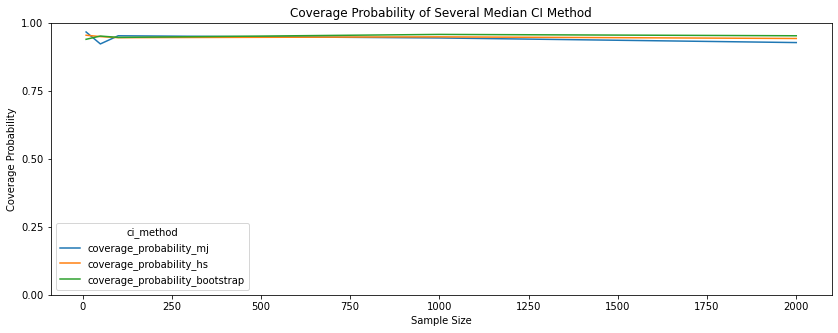

In [95]:
ci_coverage_melt = pd.melt(
    ci_coverage.copy(), id_vars='sample_sizes', 
    value_vars=['coverage_probability_mj', 'coverage_probability_hs', 'coverage_probability_bootstrap'],
    var_name='ci_method', value_name='coverage_probability'
)
# plot coverage probability
plt.figure(figsize=(14, 5))
sns.lineplot(data=ci_coverage_melt, x='sample_sizes', y='coverage_probability', hue='ci_method')
plt.yticks(np.linspace(0, 1, 5))
plt.xlabel('Sample Size')
plt.ylabel('Coverage Probability')
plt.title('Coverage Probability of Several Median CI Method')
plt.show()

In [96]:
def median_ci_hs(array, alpha=0.05, output='upper'):
    ci_l, ci_h = median_cihs(
            data=array,
            alpha=alpha
            )
    if output =='lower':
        return ci_l
    return ci_h

def get_ci_df(df):
    df_ = df.copy()
    return (df_[['city', 'price_in_rp']]\
        .groupby('city')\
        .aggregate(
            median=pd.NamedAgg(column='price_in_rp', aggfunc=np.median),
            ci_lower = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x, output='lower')),
            ci_upper = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x))
        )\
        .reset_index()\
        .sort_values('median')
    )

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'  
median_ci_jabodetabek = get_ci_df(house_df_simple)

median_ci_jabodetabek

city           median         ci_lower         ci_upper
0        Bekasi   972,500,000.00   916,777,805.81 1,050,000,000.00
3         Depok   995,000,000.00   945,417,204.91 1,050,000,000.00
1         Bogor 1,200,000,000.00 1,100,000,000.00 1,350,000,000.00
4     Tangerang 2,400,000,000.00 2,168,813,480.34 2,600,000,000.00
2   DKI Jakarta 4,500,000,000.00 3,990,000,000.00 4,900,000,000.00

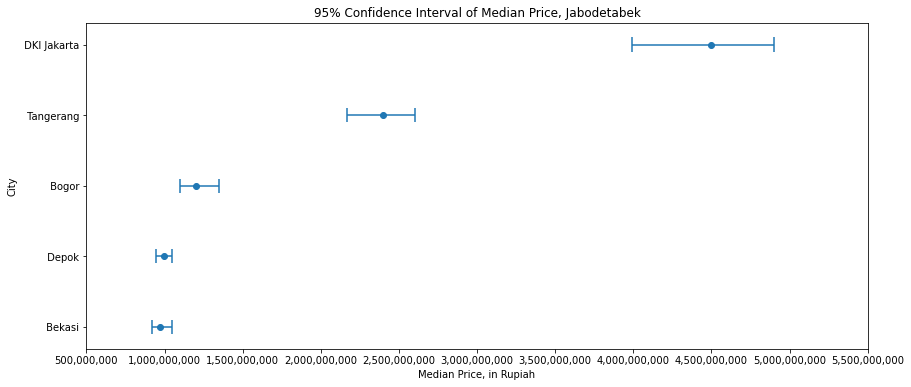

In [97]:
def plot_ci(df, title):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.hlines(y=df.city, xmin=df.ci_lower, xmax=df.ci_upper)
    y_ticks = np.array(ax.get_yticks())
    x_ticks = ax.get_xticks()
    x_ticks = x_ticks.copy()[x_ticks.copy() >= 0]
    ax.vlines(x=df.ci_lower, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.vlines(x=df.ci_upper, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.scatter(x=df['median'], y=df.city)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax.set_title(f'95% Confidence Interval of Median Price, {title}')
    ax.set_xlabel('Median Price, in Rupiah')
    ax.set_ylabel('City')

plot_ci(median_ci_jabodetabek, 'Jabodetabek')

In [98]:
median_ci_jakarta = get_ci_df(house_df_jakarta)

median_ci_jakarta

city            median         ci_lower          ci_upper
3     Jakarta Timur  1,400,000,000.00 1,050,000,000.00  2,000,000,000.00
0     Jakarta Barat  3,200,000,000.00 2,750,000,000.00  3,651,516,112.22
1     Jakarta Pusat  4,800,000,000.00   585,964,530.25 17,500,000,000.00
2   Jakarta Selatan  8,400,000,000.00 6,250,000,000.00 10,627,713,948.40
4     Jakarta Utara 10,000,000,000.00 7,700,000,000.00 12,000,000,000.00

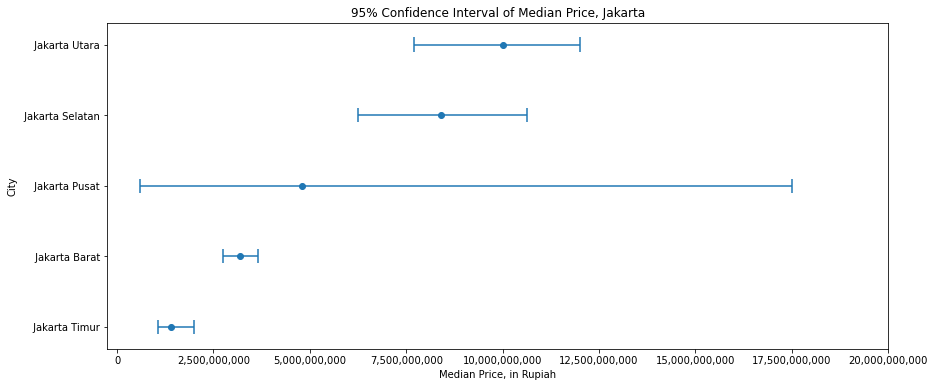

In [99]:
plot_ci(median_ci_jakarta, 'Jakarta')

## 3.2. House Price according to Certificate Type

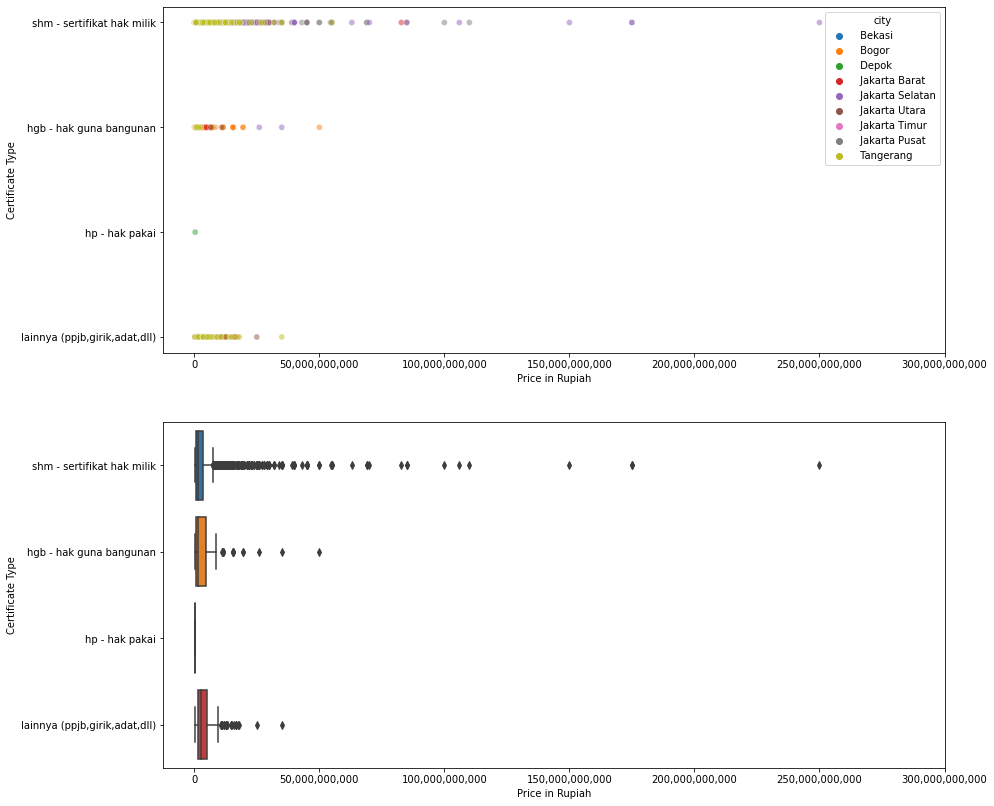

In [100]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df, y='certificate', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')

In [101]:
def median_diff(sample_1, sample_2):
    statistic = np.median(sample_1) - np.median(sample_2)
    return statistic

sample_size = 50
city = ' Bogor'
categories = ['shm - sertifikat hak milik', 'hgb - hak guna bangunan', 'lainnya (ppjb,girik,adat,dll)']
sample_1 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'shm - sertifikat hak milik')]\
        .price_in_rp.sample(sample_size).values
sample_2 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'hgb - hak guna bangunan')]\
        .price_in_rp.sample(sample_size).values
data = (sample_1, sample_2)
res = bootstrap(data, median_diff, method='basic', vectorized=False)

res.confidence_interval

ConfidenceInterval(low=-4550000000.0, high=-250000000.0)

In [102]:
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df_simple[column] = \
        pd.Categorical(
            values=house_df_simple[column],
            categories=order,
            ordered=True
            )
cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
categories = list(house_df_simple.certificate.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
records = []
sample_size = 10
for city in cities:
    df = house_df_simple[house_df_simple.city == city]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.certificate == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
                df.certificate == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })

median_df_test = pd.DataFrame(records)

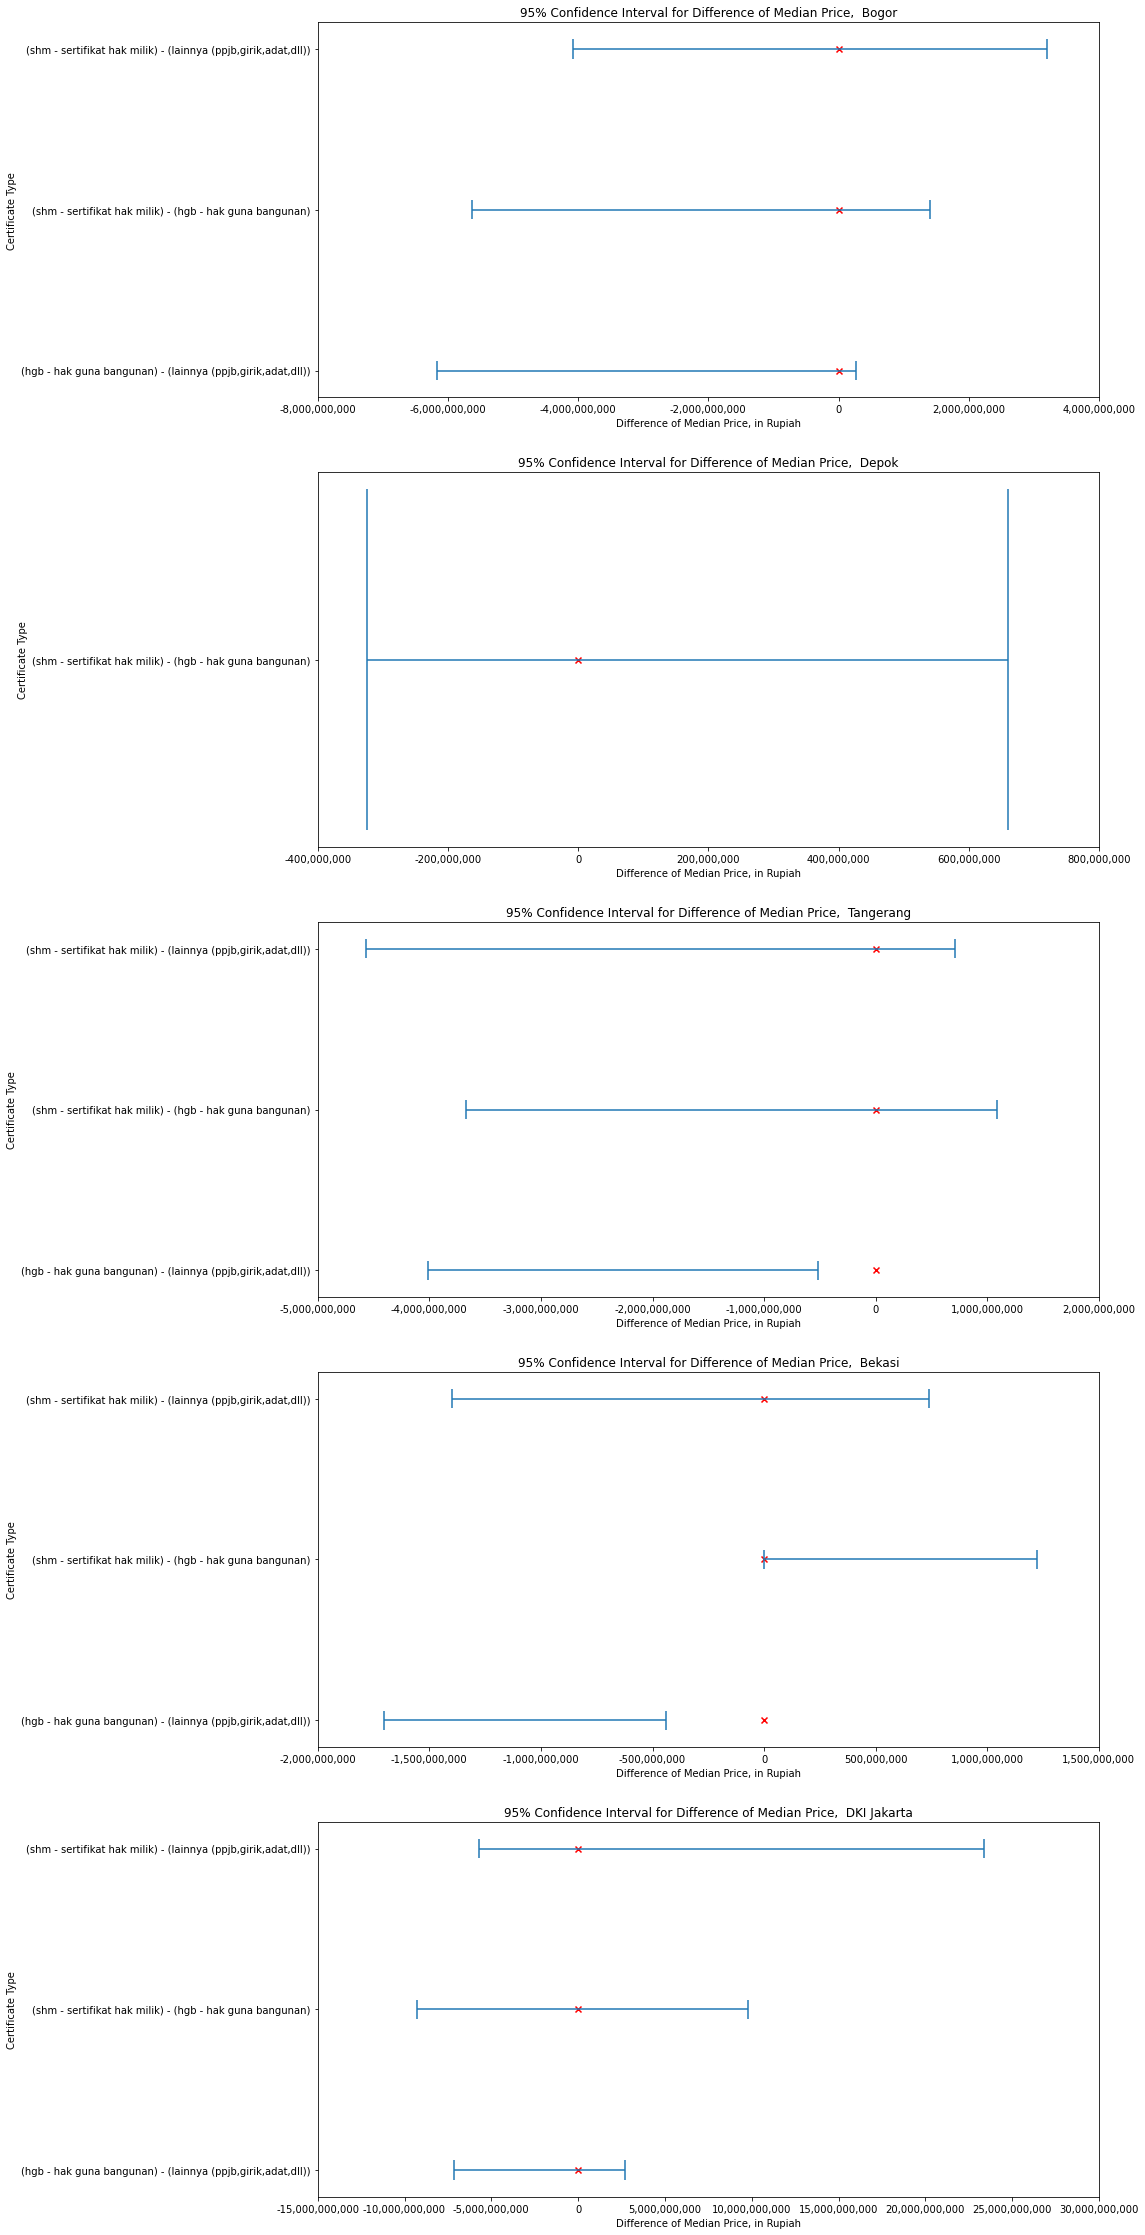

In [103]:
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 8))

for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city].sort_values('category_1')
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Certificate Type')

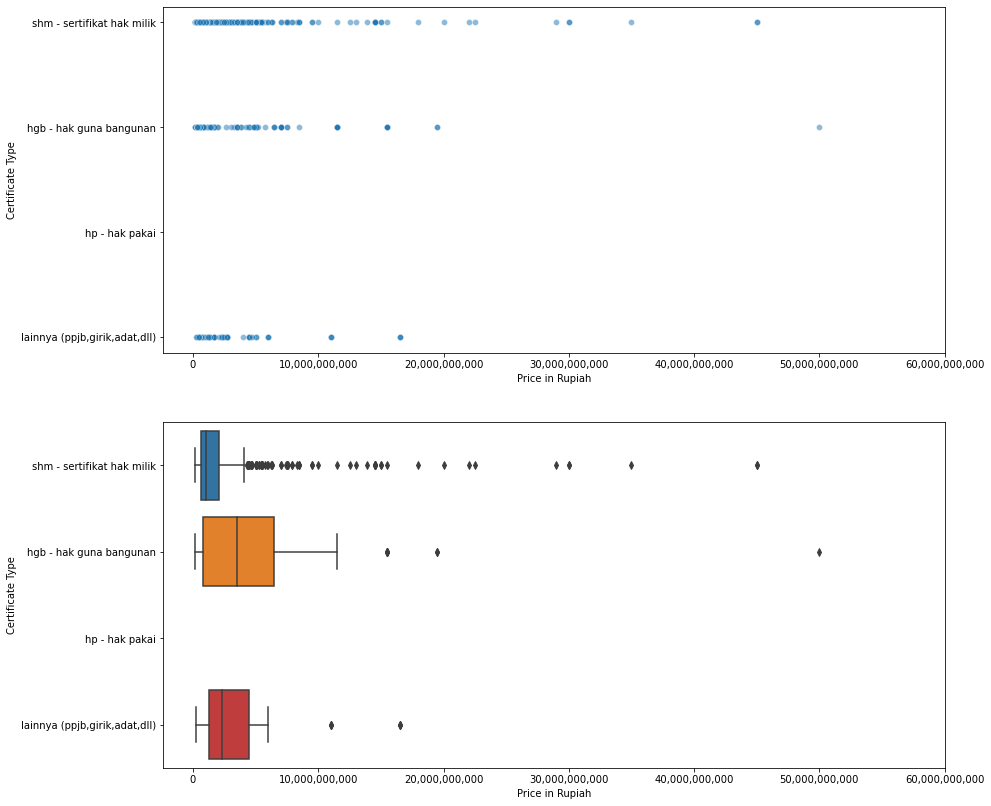

In [104]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')

## 3.3. House Price according to Property Condition

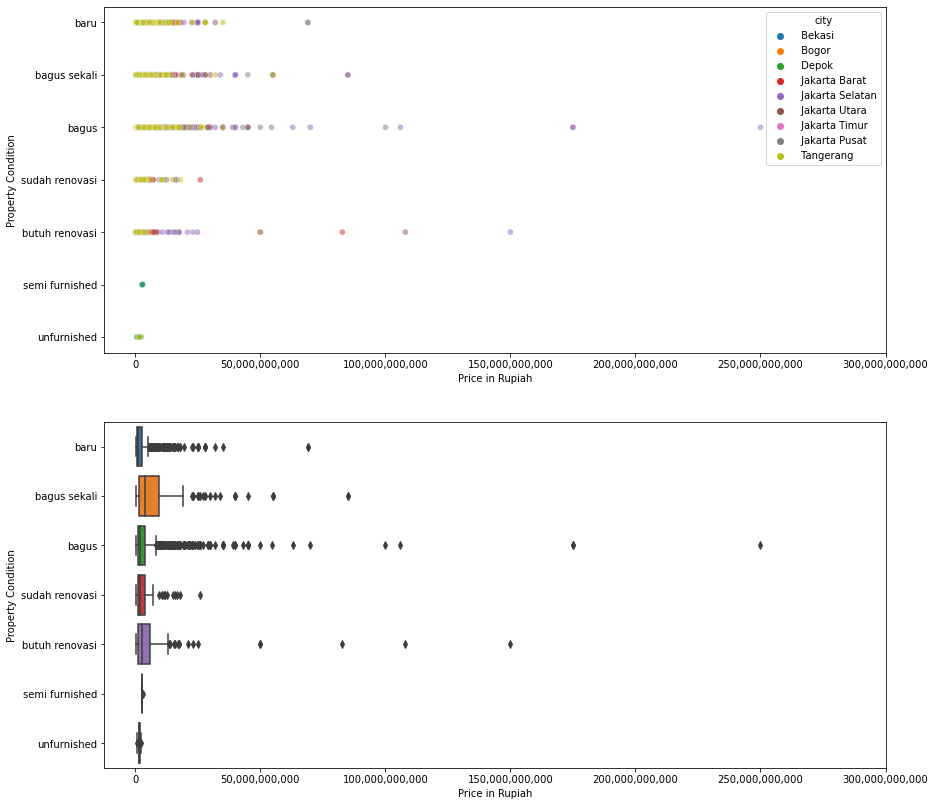

In [105]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df, y='property_condition', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='property_condition', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Property Condition')

In [106]:
cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
analyze_condition = ['baru', 'bagus sekali', 'bagus', 'sudah renovasi', 'butuh renovasi']
records = []
sample_size = 30
categories = list(house_df_simple.property_condition.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
for city in cities:
    df = house_df_simple[
        (house_df_simple.city == city) & (house_df.property_condition.isin(analyze_condition))]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.property_condition == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
               df.property_condition == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })

median_df_test = pd.DataFrame(records)

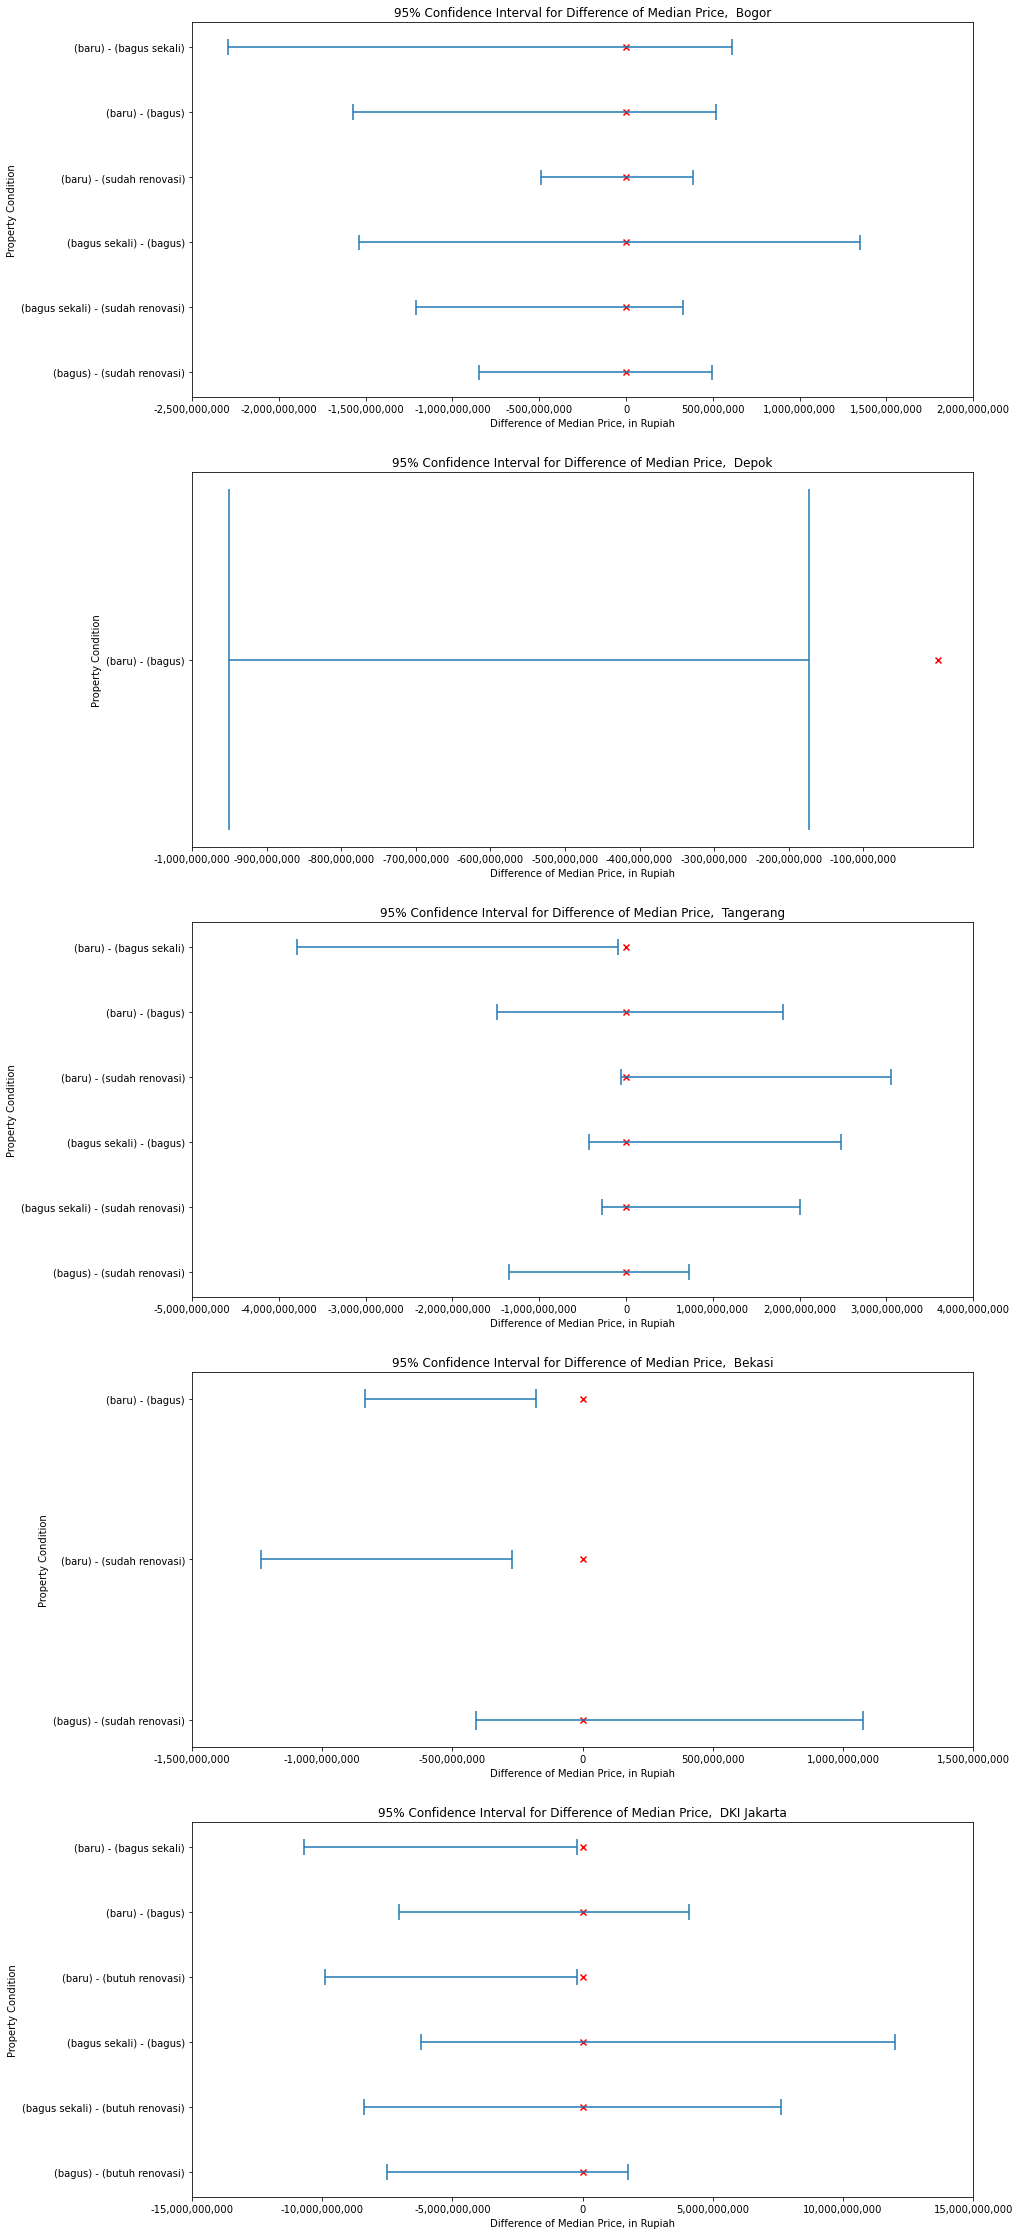

In [107]:
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 8))

for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city]
    df = df.iloc[::-1]
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Property Condition')

## 3.4. House Price according to Numerical Features

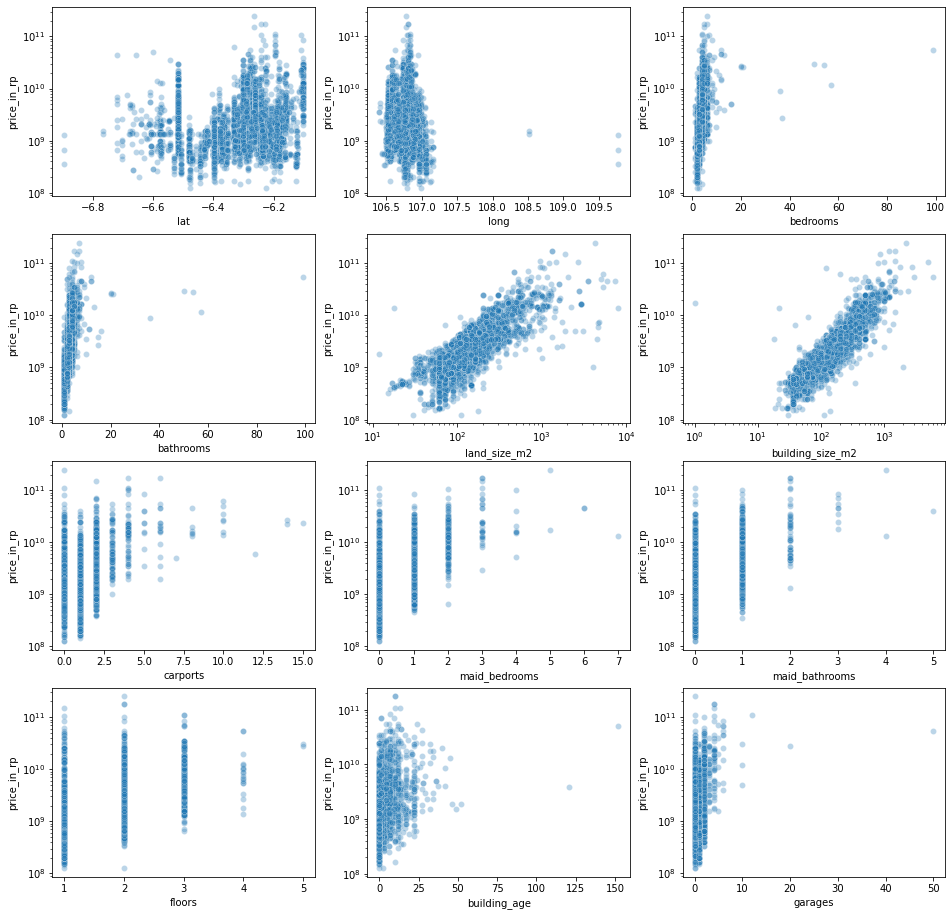

In [108]:
numerical_features = house_df\
    .select_dtypes(exclude=['object', 'category'])\
        .drop(['price_in_rp', 'year_built'], axis=1).columns

fig, ax = plt.subplots(4, 3, figsize=(16, 16))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), numerical_features):
    sns.scatterplot(data=house_df, x=feature, y='price_in_rp', alpha=0.3, ax=ax[ax_index])
    if (house_df[feature].dtypes == 'float') & (feature not in ['lat', 'long']):
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

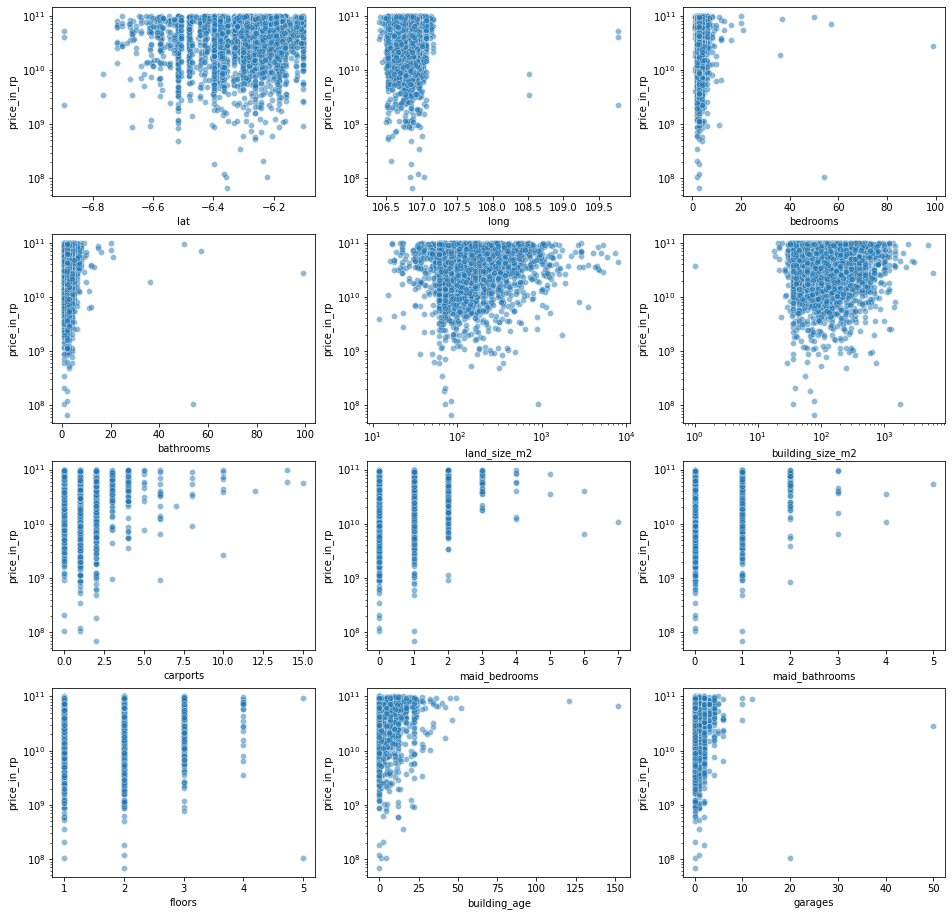

In [109]:
numerical_features = house_df\
    .select_dtypes(exclude=['object', 'category'])\
        .drop(['price_in_rp', 'year_built'], axis=1).columns

house_df_test_random = house_df.assign(
    price_in_rp = np.random.uniform(10000000, 100000000000, len(house_df.price_in_rp))
)

fig, ax = plt.subplots(4, 3, figsize=(16, 16))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), numerical_features):
    sns.scatterplot(data=house_df_test_random, x=feature, y='price_in_rp', alpha=0.5, ax=ax[ax_index])
    if (house_df[feature].dtypes == 'float') & (feature not in ['lat', 'long']):
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

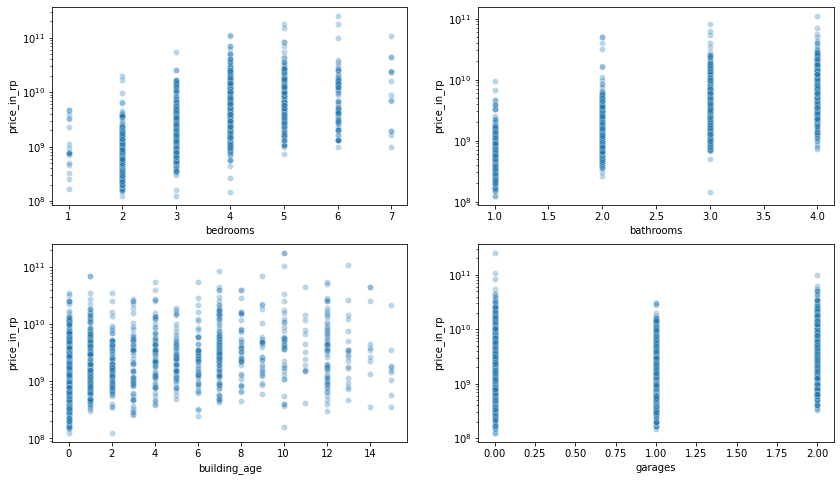

In [110]:
features = ['bedrooms', 'bathrooms', 'building_age', 'garages']

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), features):
    q_lower = np.quantile(house_df[feature].dropna().values, 0.25)
    q_upper = np.quantile(house_df[feature].dropna().values, 0.75)
    iqr = (q_upper - q_lower)
    whisker_upper = q_upper + 1.5 * iqr
    df = house_df[house_df[feature] <= whisker_upper]
    sns.scatterplot(data=df, x=feature, y='price_in_rp', alpha=0.3, ax=ax[ax_index])
    if house_df[feature].dtypes == 'float':
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

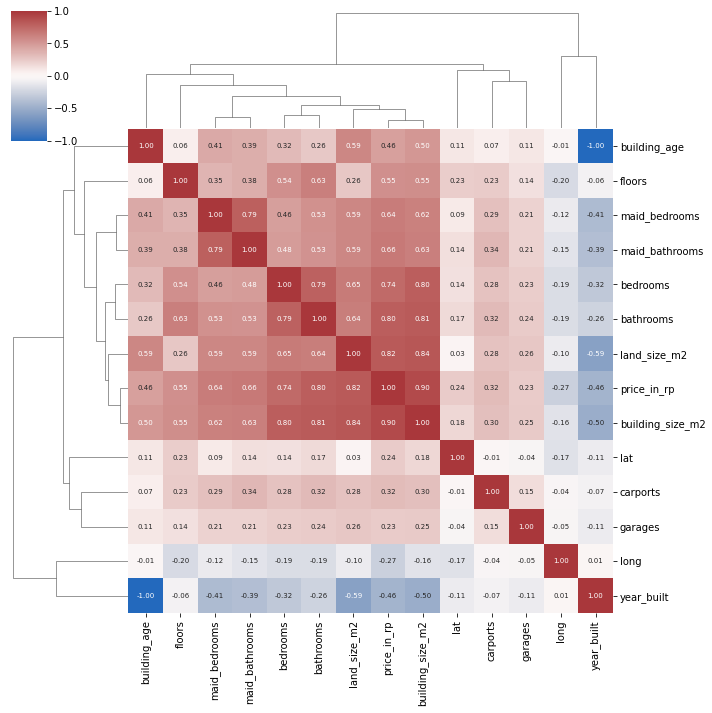

In [119]:
columns_corr = house_df.columns[~house_df.columns.isin(list(fac_columns))]
house_df_corr = house_df[columns_corr].corr(method='spearman')
sns.clustermap(house_df_corr, vmin=-1, vmax=1, center=0, cmap='vlag', annot=True, fmt='.2f', annot_kws={'size': 7})

# 4. Closing

In [120]:
house_df.to_csv('Dataset\jabodetabek_house_data_prcsd.csv', index=False)

# 5. References

1. 'rumah123.com'